# Aktuelle Limitierungen:

* Inhalte, die mehreren Fächern zugeordnet worden sind, zählen nur zu einem Fach
* Es werden nur Bearbeitungen gezählt
* Folgeevents einer Bearbeitung werden nicht zusammengefasst

In [1]:
import pandas as pd
import mysql.connector

from IPython.display import display, Markdown, HTML

db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo"
)

def cached(func):
    cache = dict()
    
    def return_func(arg):
        if (arg in cache):
            return cache[arg]
        else:
            result = func(arg)
            cache[arg] = result
            return result
    
    return return_func

def query(sql):
    c = db.cursor()
    c.execute(sql)
    
    return c.fetchall()

def querySingleton(sql):
    return [ x[0] for x in query(sql) ]

@cached
def getParent(termId):
    return querySingleton("""
        select parent_id from term_taxonomy where id = %s;
    """ % termId)[0]

def getTermName(termId):
    return querySingleton("""
        select term.name from term_taxonomy
        join term on term.id = term_taxonomy.term_id
        where term_taxonomy.id = %s;
    """ % termId)[0]

@cached
def getSubject(termId):
    if int(termId) in [79733, 81317, 20852, 87814, 87827, 85477, 87860, 75049, 76750, 87496, 75678, 91252, 91253]:
        return "Prüfungsbereich Mathematik"
    if int(termId) in [106082]:
        return getTermName(termId)
    
    parent = getParent(termId)
    grandparent = getParent(parent)
    
    if (parent == 106081):
        return getTermName(termId)
    
    return getSubject(parent) if grandparent != None else getTermName(termId)

@cached
def getSubjectFromUuid(uuid):
    taxonomyTerms = querySingleton(f"""
        select term_taxonomy_id from term_taxonomy_entity
        where term_taxonomy_entity.entity_id  = {uuid};
    """)
    
    if len(taxonomyTerms) > 0:
        return getSubject(taxonomyTerms[0])

    parents = querySingleton(f"""
        select parent_id from entity_link
        where entity_link.child_id  = {uuid};
    """)
    
    if len(parents) > 0:
        return getSubjectFromUuid(parents[0])
    
    return None

display(getSubjectFromUuid(127338))
display(getSubjectFromUuid(63496))
display(getSubjectFromUuid(1))
display(getSubjectFromUuid(170741))
display(getSubjectFromUuid(167497))

/home/kulla/.local/share/asdf/installs/python/3.9.1/lib/python3.9/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


'Chemie'

'Chemie'

None

'Prüfungsbereich Mathematik'

'Sandkasten'

In [2]:
import json

json.dumps(querySingleton("""
select distinct(entity_link.parent_id ) from event_log join entity_link on entity_link.child_id = event_log.uuid_id where event_log.event_id = 4 and event_log.date > Date("2020-02-01");
"""))

'[97101, 96936, 101383, 150542, 150631, 150638, 150297, 150298, 150553, 149913, 150299, 149915, 127687, 147399, 150317, 150315, 150313, 150311, 150306, 61144, 63994, 71474, 71485, 71496, 71507, 136472, 71960, 130809, 130539, 130683, 130505, 130576, 130567, 113684, 149967, 151713, 149948, 149923, 149951, 149925, 149893, 149929, 149935, 149946, 149919, 149982, 149939, 149955, 149953, 149911, 149991, 149992, 149993, 149943, 149932, 149937, 151984, 151988, 151992, 13751, 13753, 149290, 147049, 147016, 147034, 147028, 130895, 148109, 148111, 153686, 153697, 153699, 153701, 153703, 153705, 153726, 153732, 153734, 108229, 147354, 147355, 153742, 153885, 153887, 153889, 12653, 153988, 148115, 147342, 96580, 148693, 148131, 97271, 97288, 97306, 97443, 148133, 96733, 148907, 148537, 148137, 148532, 96735, 96740, 11617, 149192, 147041, 148926, 147006, 147022, 96737, 90208, 148157, 92244, 94614, 95935, 148527, 154959, 154960, 154962, 155004, 148529, 149787, 95938, 95940, 136110, 136114, 95941, 959

In [3]:
def read_event_log():
    df = pd.read_sql("""
        select event_log.id, event_log.actor_id, event_log.date, user.username, event_parameter_uuid.uuid_id from event_log
        join user on user.id = event_log.actor_id
        join event_parameter on event_parameter.log_id = event_log.id
        join event_parameter_uuid on event_parameter_uuid.event_parameter_id = event_parameter.id
        where event_log.event_id = 5
        and year(event_log.date) > 2018
        and user.username != "Legacy"
    """, db)
    df.set_index("id", inplace=True)
    df.rename(columns={"uuid_id": "uuid"}, inplace=True)
    df["subject"] = df["uuid"].map(getSubjectFromUuid)
    return df

event_log = read_event_log()
event_log.head(10)

,actor_id,date,username,uuid,subject
id,,,,,
252170,95850,2019-01-02 10:35:03,Leo1,127338,Chemie
252172,95850,2019-01-02 10:58:42,Leo1,127338,Chemie
252180,95849,2019-01-02 11:46:55,hernlmax,63496,Chemie
252185,95849,2019-01-02 11:51:49,hernlmax,127428,Chemie
252187,95849,2019-01-02 11:52:47,hernlmax,127428,Chemie
252189,95849,2019-01-02 11:53:00,hernlmax,127428,Chemie
252194,95849,2019-01-02 11:54:28,hernlmax,127428,Chemie
252196,95849,2019-01-02 11:56:19,hernlmax,127355,Chemie
252198,95849,2019-01-02 12:12:57,hernlmax,127432,Chemie


In [4]:
import matplotlib.pyplot as plt

def show(subject=None, lower=10, time_interval=90):
    df = event_log.copy()
    
    if subject:
        df = df[df["subject"] == subject]
        if len(df) == 0:
            return
        
    edits_per_day = compute_edits_per_day_per_user(df)
    df = edits_per_day.rolling(time_interval, min_periods=time_interval).sum()
    df.dropna(inplace=True)
    
    display(Markdown(f"### Plot Anzahl Autor:innen mit Edits >= {lower}"))
    df.apply(lambda x: x.map(lambda y: y >= lower).sum(), axis=1).plot(figsize=(10,10))
    plt.show()
    
    df2 = pd.DataFrame({
        "edits": df.loc[df.index[-1]],
        "edits_before": df.loc[df.index[-1-time_interval]],
    })
    
    count = (df2["edits"] >= lower).sum()
    
    display(Markdown(f"Anzahl Autor:innen mit Edits >= {lower}: {count}"))
    
    display(Markdown(f"### Autor:innen mit aktuellen Edits >= {lower}"))
    d = df2[df2["edits"] >= lower][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)
    
    display(Markdown(f"### Verlorene Autor:innen mit aktuellen Edits < {lower} und vorher Edits >= {lower}"))
    d = df2[(df2["edits"] < lower) & (df2["edits_before"] >= lower)][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)
    
    display(Markdown(f"### Neue Autor:innen (Personen, die in den letzten {time_interval} Tagen dazugekommen sind)"))
    df3 = edits_per_day.cumsum()
    df3 = pd.DataFrame({
        "edits": df3.loc[df.index[-1]],
        "edits_before": df3.loc[df.index[-1-time_interval]],
    })
    d = df3[(df3["edits"] > 0) & (df3["edits_before"] == 0)][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)
    
    display(Markdown(f"### Neue Autor:innen (Personen, die in den letzten {time_interval} Tagen dazugekommen sind) + Edits < {lower}"))
    d = df3[(df3["edits"] < lower) & (df3["edits"] > 0) & (df3["edits_before"] == 0)][["edits"]]
    d.sort_values("edits", inplace=True, ascending=False)
    display(d)

def compute_edits_per_day_per_user(df, since=4*365.25):
    current_date = df["date"].max()
    df = df[df["date"] > current_date - pd.Timedelta(days=since)]
    
    def user_df(username):
        #display(df.head())
        u = df[df["username"] == username].copy()
        u.set_index("date", inplace=True)
        u = u.resample("D").count()[["actor_id"]]
        u.rename(columns={"actor_id": username}, inplace=True)
        return u
    
    df = pd.concat([user_df(u) for u in df["username"].unique()], axis=1)
    df.fillna(0, inplace=True)
    
    return df

#show()

### Plot Anzahl Autor:innen mit Edits >= 10

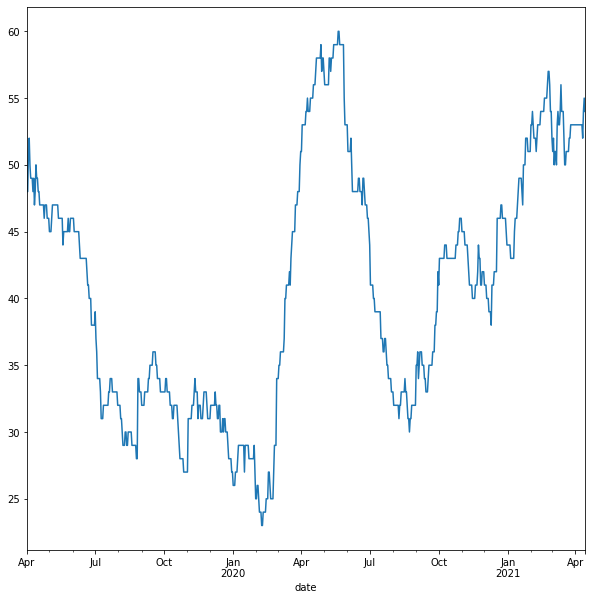

Anzahl Autor:innen mit Edits >= 10: 54

### Autor:innen mit aktuellen Edits >= 10

,edits
WandaPaetzold,1399.0
kathongi,1146.0
LinaMaria,716.0
Annika-Hemlein,552.0
Kowalsky,490.0
Katrin_K,488.0
MarK97,317.0
Karin,284.0
dal,223.0
HannaKulke,201.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
gavin,7.0
03gymnasium_rahden,7.0
Menuja,5.0
10gymnasium_rahden,4.0
07gymnasium_rahden,4.0
04gymnasium_rahden,4.0
Renate,2.0
02gymnasium_rahden,2.0
05gymnasium_rahden,2.0
12gymnasium-rahden,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Annika-Hemlein,552.0
Katrin_K,488.0
Matheo,118.0
Corinna,75.0
Rami,71.0
Anton_Zikmund,43.0
Wo_Fo,32.0
Tom4Mathe,29.0
Pseudo_Informatiker,28.0
KerstinPecher,20.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
ClaudiaLK,9.0
yannikwehr,3.0
Rebecca_8492,2.0
ralfg1,2.0
marwlabs,2.0
AhanaPramanik,2.0
The-Professor,1.0
nuessa,1.0
Teachers_angel,1.0
Torben,1.0


In [5]:
show()

### Plot Anzahl Autor:innen mit Edits >= 100

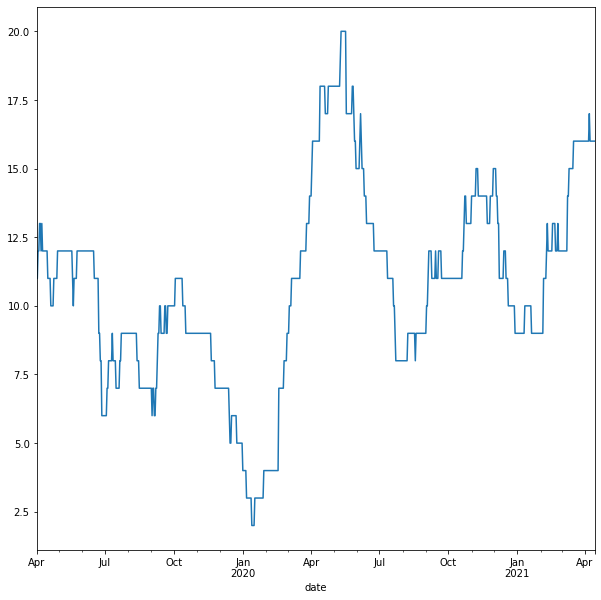

Anzahl Autor:innen mit Edits >= 100: 16

### Autor:innen mit aktuellen Edits >= 100

,edits
WandaPaetzold,1399.0
kathongi,1146.0
LinaMaria,716.0
Annika-Hemlein,552.0
Kowalsky,490.0
Katrin_K,488.0
MarK97,317.0
Karin,284.0
dal,223.0
HannaKulke,201.0


### Verlorene Autor:innen mit aktuellen Edits < 100 und vorher Edits >= 100

,edits
hxwalther,89.0
Madlen,85.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Annika-Hemlein,552.0
Katrin_K,488.0
Matheo,118.0
Corinna,75.0
Rami,71.0
Anton_Zikmund,43.0
Wo_Fo,32.0
Tom4Mathe,29.0
Pseudo_Informatiker,28.0
KerstinPecher,20.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 100

,edits
Corinna,75.0
Rami,71.0
Anton_Zikmund,43.0
Wo_Fo,32.0
Tom4Mathe,29.0
Pseudo_Informatiker,28.0
KerstinPecher,20.0
Mathes,20.0
Gianluca,14.0
Rahuldangi2407,14.0


In [6]:
show(lower=100)

### Plot Anzahl Autor:innen mit Edits >= 50

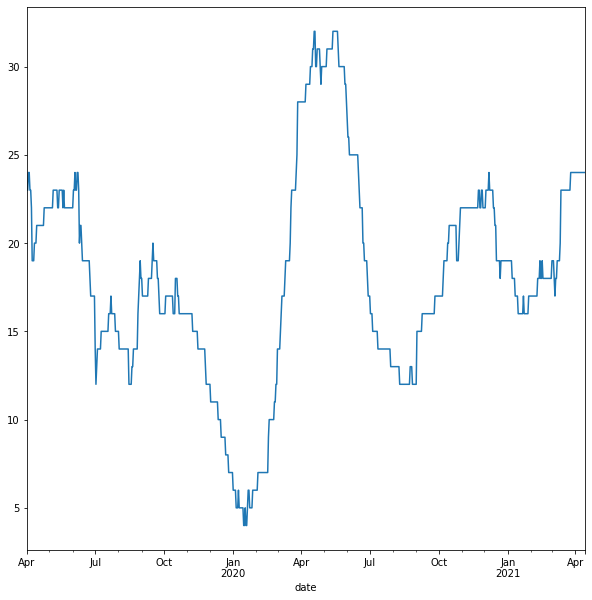

Anzahl Autor:innen mit Edits >= 50: 24

### Autor:innen mit aktuellen Edits >= 50

,edits
WandaPaetzold,1399.0
kathongi,1146.0
LinaMaria,716.0
Annika-Hemlein,552.0
Kowalsky,490.0
Katrin_K,488.0
MarK97,317.0
Karin,284.0
dal,223.0
HannaKulke,201.0


### Verlorene Autor:innen mit aktuellen Edits < 50 und vorher Edits >= 50

,edits
Theresa_Rudolph,34.0
wolfgang,25.0
MGoeldner,19.0
Marc_Ho,17.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Annika-Hemlein,552.0
Katrin_K,488.0
Matheo,118.0
Corinna,75.0
Rami,71.0
Anton_Zikmund,43.0
Wo_Fo,32.0
Tom4Mathe,29.0
Pseudo_Informatiker,28.0
KerstinPecher,20.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 50

,edits
Anton_Zikmund,43.0
Wo_Fo,32.0
Tom4Mathe,29.0
Pseudo_Informatiker,28.0
KerstinPecher,20.0
Mathes,20.0
Gianluca,14.0
Rahuldangi2407,14.0
Adrian_B,13.0
ClaudiaLK,9.0


In [7]:
show(lower=50)

In [8]:
event_log["subject"].unique()

array(['Chemie', None, 'Mathe', 'Sandkasten', 'Englisch', 'Community',
       'Nachhaltigkeit', 'Physik', 'Prüfungsbereich Mathematik',
       'Lerntipps', 'Informatik', 'Deutsch als Zweit- und Fremdsprache',
       'Biologie', 'Kommunikation', 'Rechnungswesen', 'Geschichte',
       'Psychologie', 'Wirtschaft', 'Politik', 'mathÃ©matiques',
       'Geographie', 'à®‡à®²à®•à¯\x8dà®•à®£à®®à¯\x8d', 'Medienbildung',
       'Testbereich', 'Latein', 'à®µà®°à®²à®¾à®±à¯\x81',
       'Deutsch als Fremdsprache', 'MatemÃ¡ticas',
       'Conseils pour apprendre', 'Sex Education', 'Musik', 'Forensik',
       'Italienisch'], dtype=object)

## Fach: Mathe

### Plot Anzahl Autor:innen mit Edits >= 10

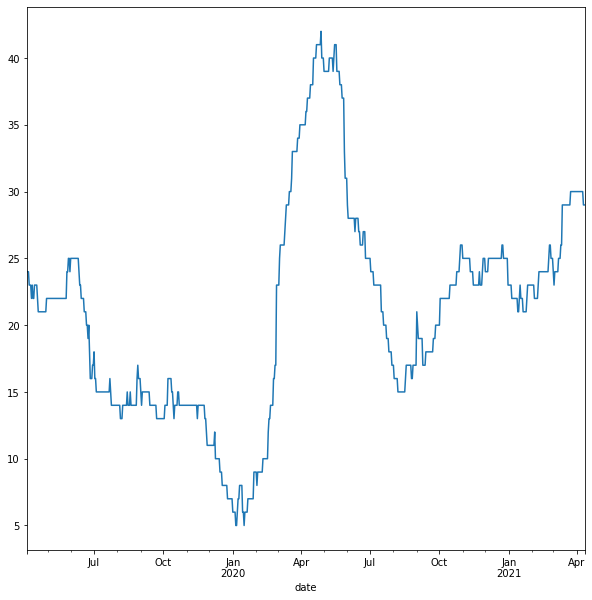

Anzahl Autor:innen mit Edits >= 10: 29

### Autor:innen mit aktuellen Edits >= 10

,edits
WandaPaetzold,1224.0
kathongi,1081.0
Katrin_K,434.0
Annika-Hemlein,425.0
Kowalsky,389.0
MarK97,305.0
HannaKulke,201.0
dal,160.0
Karin,120.0
metzgaria,100.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
Renate,0.0
anne22,0.0
hp,0.0
annak,0.0
isabellad,0.0
Carolin,0.0
Wolli2016,0.0
LukasHuckfeldt,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Katrin_K,434.0
Annika-Hemlein,425.0
lea_b,93.0
Matheo,67.0
amankumar1419,60.0
Madlen,50.0
Anton_Zikmund,43.0
Rami,23.0
Mathes,20.0
Corinna,11.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Tom4Mathe,6.0
Gianluca,5.0
ClaudiaLK,4.0
yannikwehr,3.0
ralfg1,2.0
marwlabs,2.0
qdaffner,1.0
koehlertim,1.0
Herr_Paulus,1.0
Aurelia-Lilith-Spellmann,1.0


## Fach: Chemie

### Plot Anzahl Autor:innen mit Edits >= 10

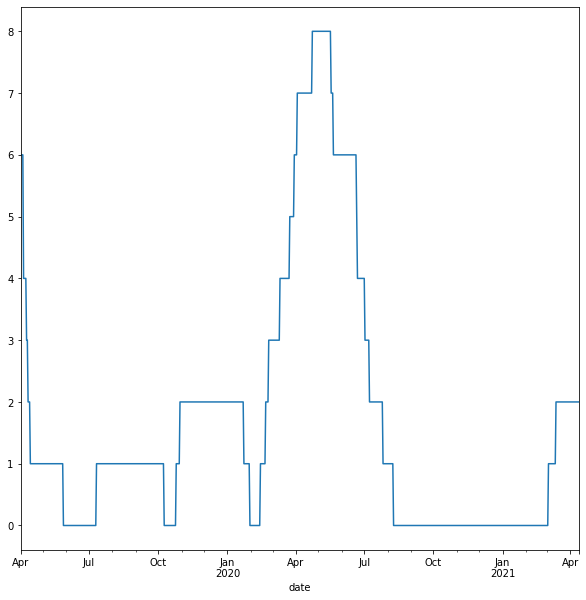

Anzahl Autor:innen mit Edits >= 10: 2

### Autor:innen mit aktuellen Edits >= 10

,edits
WandaPaetzold,36.0
Rubikscube,13.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Rubikscube,13.0
Mathewally,5.0
Matheo,4.0
Annika-Hemlein,1.0
Rami,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Mathewally,5.0
Matheo,4.0
Annika-Hemlein,1.0
Rami,1.0


## Fach: Physik

### Plot Anzahl Autor:innen mit Edits >= 10

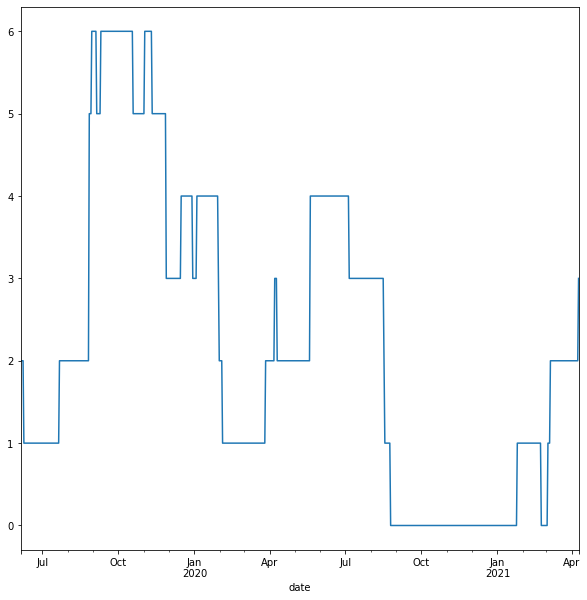

Anzahl Autor:innen mit Edits >= 10: 3

### Autor:innen mit aktuellen Edits >= 10

,edits
Matheo,28.0
Kowalsky,10.0
WandaPaetzold,10.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Matheo,28.0
dal,1.0
metzgaria,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
dal,1.0
metzgaria,1.0


## Fach: Nachhaltigkeit

### Plot Anzahl Autor:innen mit Edits >= 10

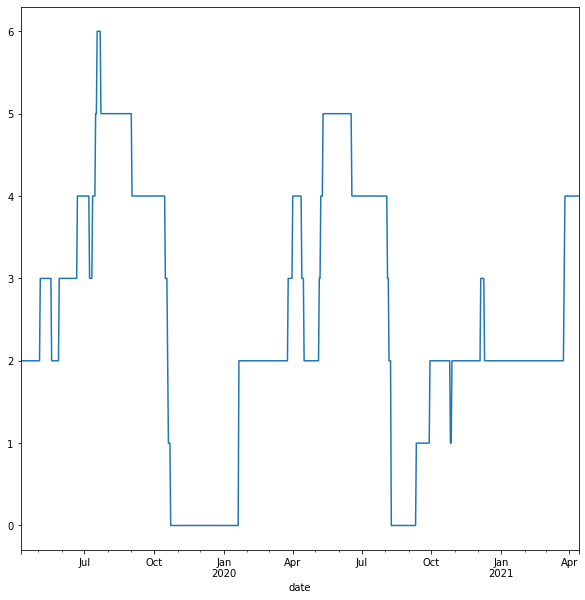

Anzahl Autor:innen mit Edits >= 10: 4

### Autor:innen mit aktuellen Edits >= 10

,edits
Gesine,64.0
Corinna,23.0
Nanami,17.0
WandaPaetzold,17.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Corinna,23.0
Mathewally,5.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Mathewally,5.0


## Fach: Biologie

### Plot Anzahl Autor:innen mit Edits >= 10

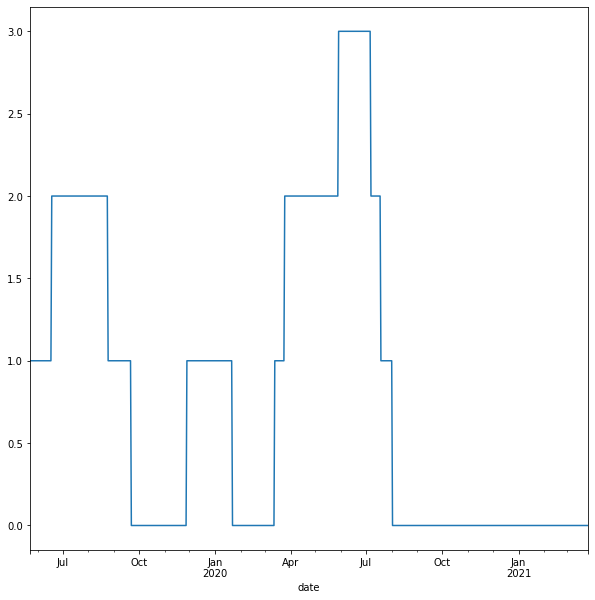

Anzahl Autor:innen mit Edits >= 10: 0

### Autor:innen mit aktuellen Edits >= 10

,edits


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits


## Fach: Sandkasten

### Plot Anzahl Autor:innen mit Edits >= 10

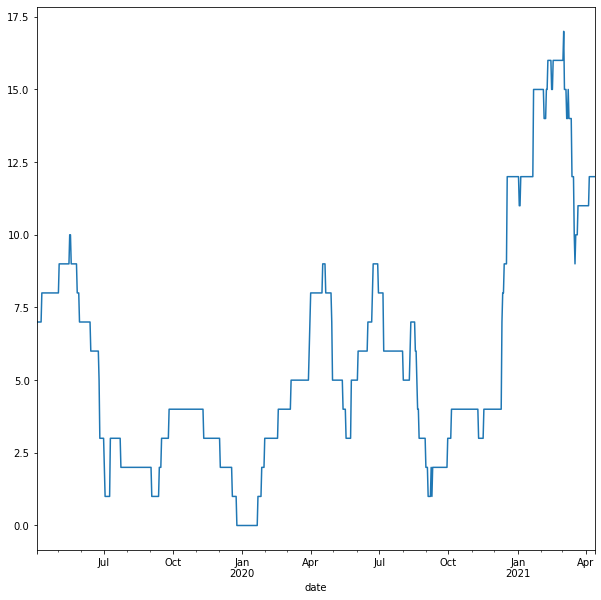

Anzahl Autor:innen mit Edits >= 10: 12

### Autor:innen mit aktuellen Edits >= 10

,edits
Kowalsky,55.0
kdkeller,30.0
kathongi,26.0
Tom4Mathe,23.0
Karin,22.0
Gesine,19.0
dal,17.0
Matheo,16.0
Corinna,16.0
WandaPaetzold,11.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
03gymnasium_rahden,7.0
10gymnasium_rahden,4.0
04gymnasium_rahden,4.0
07gymnasium_rahden,4.0
05gymnasium_rahden,2.0
02gymnasium_rahden,2.0
12gymnasium-rahden,1.0
Vithusha,0.0
PaulMusikus,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Tom4Mathe,23.0
Matheo,16.0
Corinna,16.0
anne22,7.0
Adrian_B,3.0
ClaudiaLK,3.0
Mathewally,3.0
metzgaria,2.0
gruenerBogen,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
anne22,7.0
Adrian_B,3.0
ClaudiaLK,3.0
Mathewally,3.0
metzgaria,2.0
gruenerBogen,1.0


## Fach: Prüfungsbereich Mathematik

### Plot Anzahl Autor:innen mit Edits >= 10

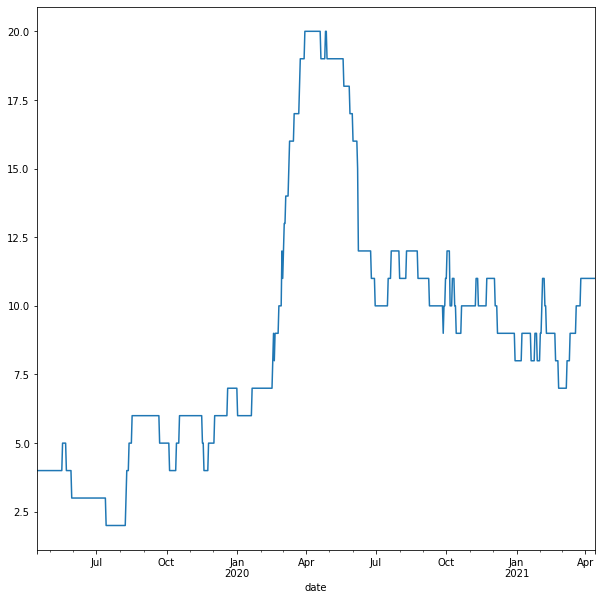

Anzahl Autor:innen mit Edits >= 10: 11

### Autor:innen mit aktuellen Edits >= 10

,edits
Karin,138.0
Astor,112.0
Mathewally,104.0
WandaPaetzold,89.0
Rami,45.0
Kowalsky,38.0
dal,31.0
Hersheysoldier,22.0
kathongi,21.0
MGoeldner,19.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
Flora_Jana,2.0
Theresa_Rudolph,0.0
janlouiebas,0.0
Taulant-Osmani,0.0
lea_b,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Mathewally,104.0
Rami,45.0
Katrin_K,6.0
Annika-Hemlein,4.0
ClaudiaLK,2.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Katrin_K,6.0
Annika-Hemlein,4.0
ClaudiaLK,2.0


## Fach: Geographie

### Plot Anzahl Autor:innen mit Edits >= 10

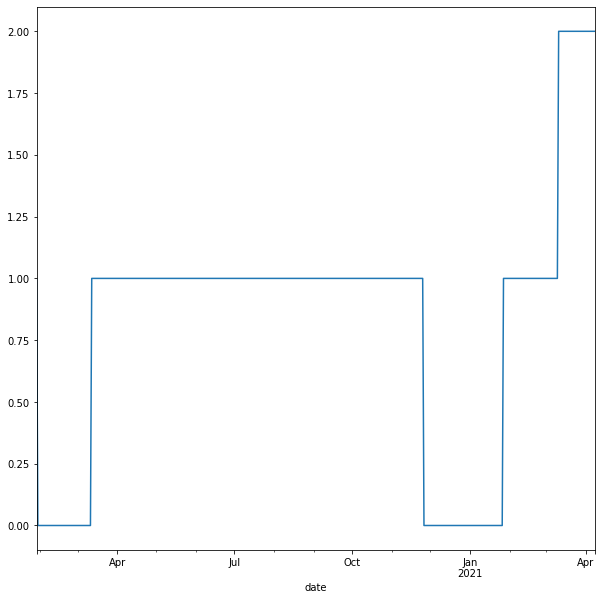

Anzahl Autor:innen mit Edits >= 10: 2

### Autor:innen mit aktuellen Edits >= 10

,edits
Katrin_K,46.0
schubertsophia,21.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Katrin_K,46.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits


## Fach: Geschichte

### Plot Anzahl Autor:innen mit Edits >= 10

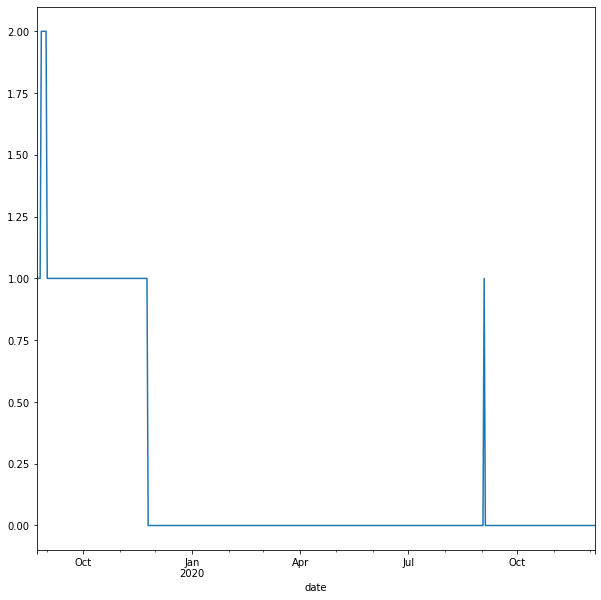

Anzahl Autor:innen mit Edits >= 10: 0

### Autor:innen mit aktuellen Edits >= 10

,edits


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits


## Fach: Community

### Plot Anzahl Autor:innen mit Edits >= 10

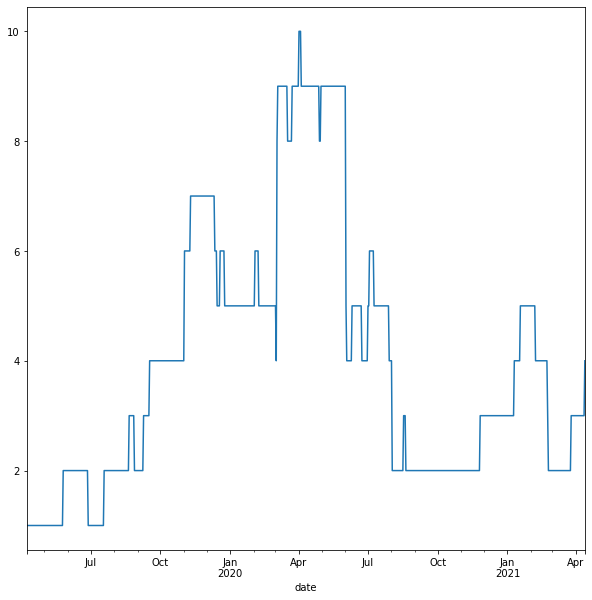

Anzahl Autor:innen mit Edits >= 10: 4

### Autor:innen mit aktuellen Edits >= 10

,edits
LinaMaria,274.0
lrodriguez,48.0
Corinna,25.0
KerstinPecher,20.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits
kathongi,5.0
lea_b,0.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Corinna,25.0
KerstinPecher,20.0
Gianluca,9.0
Mathewally,5.0
Matheo,2.0
Rami,2.0
Katrin_K,2.0
Rebecca_8492,2.0
williamwilly,1.0
sellmyhousefast,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Gianluca,9.0
Mathewally,5.0
Matheo,2.0
Rami,2.0
Katrin_K,2.0
Rebecca_8492,2.0
williamwilly,1.0
sellmyhousefast,1.0
reallpk,1.0
Karin,1.0


## Fach: Informatik

### Plot Anzahl Autor:innen mit Edits >= 10

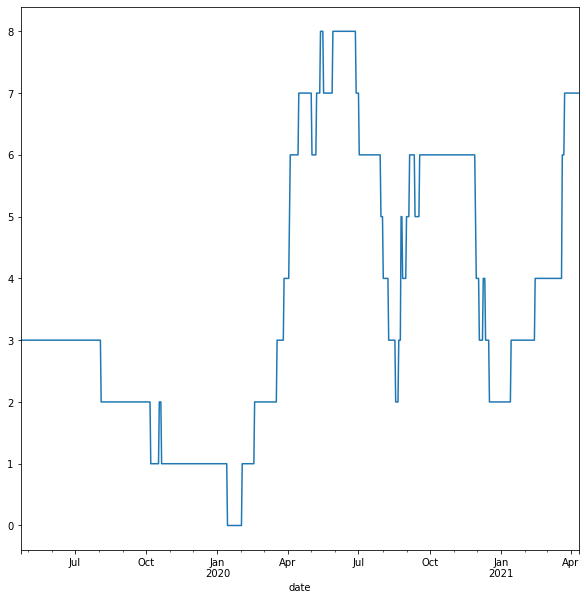

Anzahl Autor:innen mit Edits >= 10: 7

### Autor:innen mit aktuellen Edits >= 10

,edits
hxwalther,83.0
metzgaria,71.0
gavin,42.0
hwlang,29.0
Pseudo_Informatiker,28.0
opamp,24.0
dal,14.0


### Verlorene Autor:innen mit aktuellen Edits < 10 und vorher Edits >= 10

,edits


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind)

,edits
Pseudo_Informatiker,28.0
dal,14.0
Mathewally,5.0
Matheo,1.0


### Neue Autor:innen (Personen, die in den letzten 90 Tagen dazugekommen sind) + Edits < 10

,edits
Mathewally,5.0
Matheo,1.0


In [9]:
for subject in ["Mathe", "Chemie", "Physik",
                  "Nachhaltigkeit", "Biologie", "Sandkasten", "Prüfungsbereich Mathematik",
               "Geographie", "Geschichte", "Community", "Informatik"]:
    
    display(Markdown(f"## Fach: {subject}"))
    show(subject=subject)